In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

In [2]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, printDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleRegular, emitParticlesRegular, emitParticlesSDF
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.sphOps import sphOperationStates
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.plotting import scatterPlotFluid, scatterPlotFluidSymmetric, plotImplicitSDF
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorField, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco
from diffSPH.v2.modules.surfaceDetection import computeSurfaceDistance, getStableSurfaceNormal
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

In [3]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 64
    },
    'compute':{
        'device': 'cuda'
    },
    'kernel':{
        'name': 'Wendland2'
    },
    "neighborhood":{
        "scheme": "compact"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.], device='cuda:0'),
  'maxExtent': tensor([1., 1.], device='cuda:0'),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True], device='cuda:0')},
 'particle': {'nx': 64,
  'dx': tensor(0.0312, device='cuda:0'),
  'support': tensor(0.1186, device='cuda:0'),
  'defaultVolume': tensor(0.0010, device='cuda:0'),
  'defaultSupport': tensor(0.1186, device='cuda:0'),
  'volume': tensor(0.0010, device='cuda:0'),
  'smoothingLength': tensor(0.0625, device='cuda:0')},
 'compute': {'device': 'cuda', 'precision': 'float32', 'dtype': torch.float32},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': tensor(45.2390, device='cuda:0'),
  'function': <diffSPH.kernels.KernelWrapper at 0x7f6d69b6da90>,
  'kernelScale': tensor(1.8974, device='cuda:0')},
 'neighborhood': {'scheme': 'compact', 'verletScale': 1.5},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'simulation': {'correc

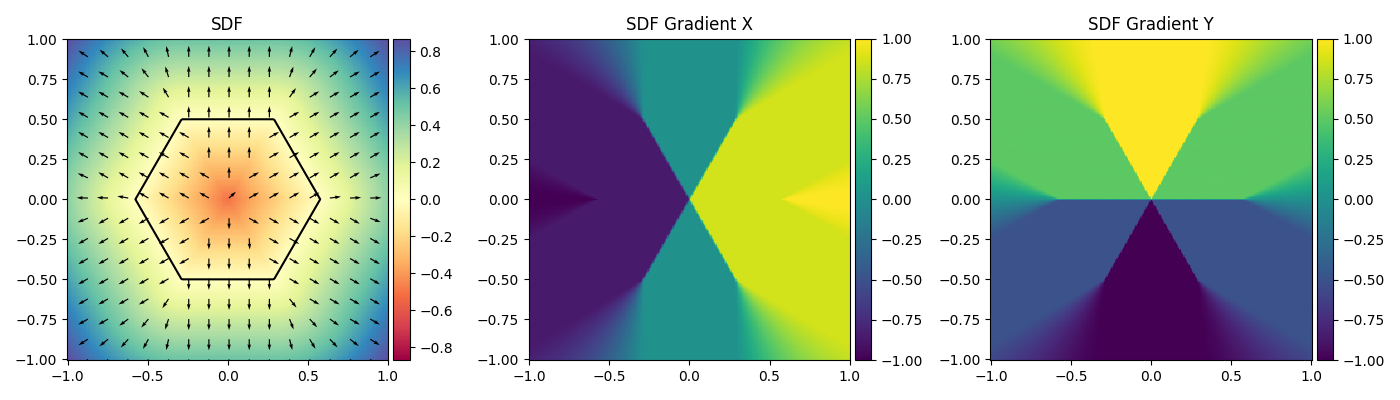

In [4]:
from diffSPH.v2.plotting import *
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from diffSPH.v2.noise import generateNoise

ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sphere_a
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [5]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import filterParticlesWithSDF

particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
particlesA = particlesA.to(config['compute']['device'])
volumeA = volumeA.to(config['compute']['device'])


In [6]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import filterParticlesWithSDF

factor = 1
# particlesB, volumeB = sampleRegular(dx / factor, dim, minExtent, domainMax, targetNeighbors, True, k)
# hB = volumeToSupport(volumeB, targetNeighbors, dim)
# areasB = particlesB.new_ones(particlesB.shape[0]) * volumeA
# onesB = particlesB.new_ones(particlesB.shape[0])
# supportsB = particlesB.new_ones(particlesB.shape[0]) * h
h = volumeToSupport(volumeA, config['kernel']['targetNeighbors'], config['domain']['dim'])

maskedA, maskA, sdfValues, sdfGradients = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)

In [7]:
print(maskA.shape)

torch.Size([4096])


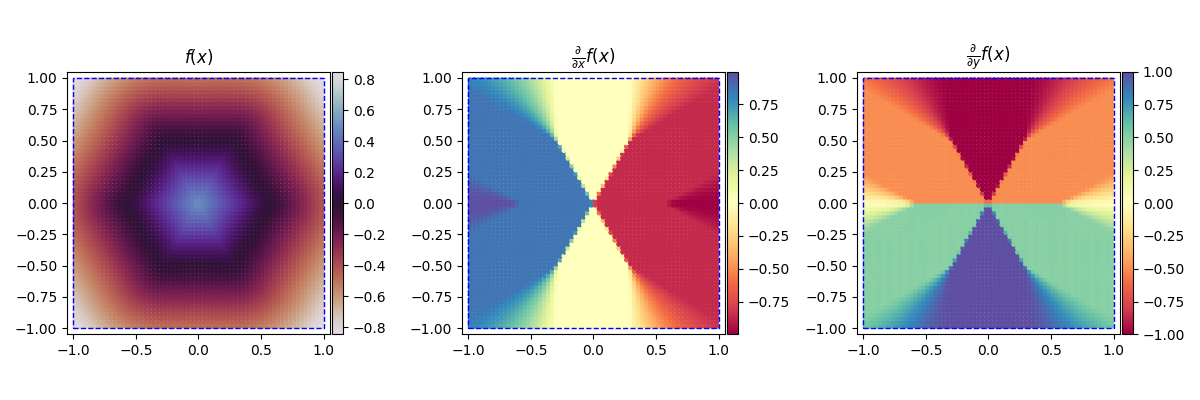

In [8]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotSymmetric(fig, axis[0,0], particlesA, sdfValues, config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], particlesA, sdfGradients[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], particlesA, sdfGradients[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8)

fig.tight_layout()

In [9]:
from typing import List
def sampleSDF(sdf, config):
    particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
    
    particlesA = particlesA.to(config['compute']['device'])
    volumeA = volumeA.to(config['compute']['device'])
    h = volumeToSupport(volumeA, config['kernel']['targetNeighbors'], config['domain']['dim'])

    # print(particlesA.shape, volumeA, h)

    maskedA, maskA, sdfValues, sdfGradients = filterParticlesWithSDF(particlesA, sdf, h, -1e-4)

    return particlesA[maskA], volumeA, sdfValues[maskA], sdfGradients[maskA]
    

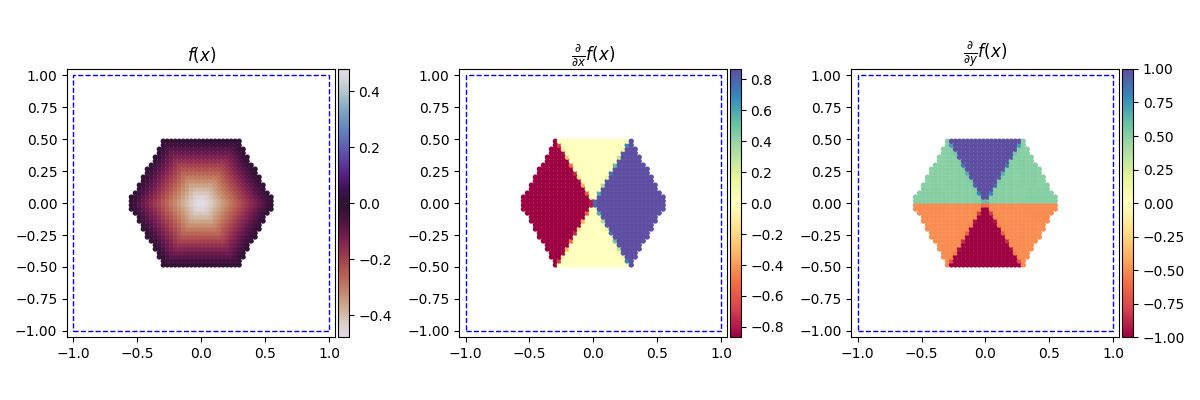

In [10]:
boundaryParticles, boundaryVolumes, boundarySDF, boundaryNormals = sampleSDF(sdf, config)

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotSymmetric(fig, axis[0,0], boundaryParticles, boundarySDF, config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
scatterPlotSymmetric(fig, axis[0,1], boundaryParticles, boundaryNormals[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
scatterPlotSymmetric(fig, axis[0,2], boundaryParticles, boundaryNormals[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8)

fig.tight_layout()

In [11]:
from diffSPH.v2.sampling import sampleParticles
fluidState,_ = sampleParticles(config)
# print(fluidState)
# print(config)
from typing import List

def sampleSDF_regular(sdf, config):
    particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
    
    particlesA = particlesA.to(config['compute']['device'])
    volumeA = volumeA.to(config['compute']['device'])
    h = volumeToSupport(volumeA, config['kernel']['targetNeighbors'], config['domain']['dim'])

    # print(particlesA.shape, volumeA, h)

    maskedA, maskA, sdfValues, sdfGradients = filterParticlesWithSDF(particlesA, sdf, h, -1e-4)

    return particlesA[maskA], volumeA, sdfValues[maskA], sdfGradients[maskA]
    
from diffSPH.v2.sampling import sampleSDF_contour
def sampleBoundaryParticles(particleState, sdfs, config, mode = 'regular'):
    
    # h = volumeToSupport(config['particle']['support'], config['kernel']['targetNeighbors'], config['domain']['dim'])
    # print(particleState)
    # print(particleState['fluidPositions'].shape)
    fluidMask = torch.ones(particleState['positions'].shape[0], dtype = torch.bool, device = config['compute']['device'])
    h = particleState['supports'].min().cpu().item()
    boundaryPositions = []
    boundaryVolumes = []
    boundaryDistances = []
    boundaryNormals = []
    boundaryBodyIDs = []
    distances = particleState['distances'] if 'distances' in particleState else torch.ones(particleState['positions'].shape[0], dtype = torch.float32, device = config['compute']['device']) * 1e8
    normals = particleState['normals'] if 'normals' in particleState else torch.zeros(particleState['positions'].shape[0], config['domain']['dim'], dtype = torch.float32, device = config['compute']['device'])

    for i, sdf in enumerate(sdfs):
        maskedA, maskA, sdfValues, sdfGradients = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
        fluidMask = fluidMask & maskA

        normals[sdfValues < distances,:] = sdfGradients[sdfValues < distances,:]
        distances[sdfValues < distances] = sdfValues[sdfValues < distances] 
        if mode == 'regular':
            boundaryPosition, boundaryVolume, boundaryDistance, boundaryNormal = sampleSDF_regular(sdf, config)
        else:
            boundaryPosition, boundaryVolume, boundaryDistance, boundaryNormal = sampleSDF_contour(sdf, config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), 255, h =h ,dx = config['particle']['dx'], internalBands= 3, externalBands=0)
        boundaryPositions.append(boundaryPosition.to(config['compute']['device']))
        boundaryVolumes.append(boundaryVolume * boundaryPosition.new_ones(boundaryPosition.shape[0]))
        boundaryDistances.append(boundaryDistance.to(config['compute']['device']))
        boundaryNormals.append(boundaryNormal.to(config['compute']['device']))
        boundaryBodyIDs.append(boundaryPosition.new_ones(boundaryPosition.shape[0]).to(config['compute']['device']) * i)

    boundaryPositions = torch.cat(boundaryPositions, dim = 0)
    boundaryVolumes = torch.cat(boundaryVolumes, dim = 0)
    boundaryDistances = torch.cat(boundaryDistances, dim = 0)
    boundaryNormals = torch.cat(boundaryNormals, dim = 0)
    boundaryBodyIDs = torch.cat(boundaryBodyIDs, dim = 0)

    particleState['distances'] = distances
    particleState['normals'] = normals

    return boundaryPositions, boundaryVolumes, boundaryDistances, boundaryNormals, boundaryBodyIDs, fluidMask

boundaryParticles, boundaryVolumes, boundaryDistances, boundaryNormals, boundaryBodyIDs, fluidMask = sampleBoundaryParticles(fluidState, [sdf], config, 'sdf')

for k in fluidState:
    # print(k)
    if isinstance(fluidState[k], torch.Tensor):
        fluidState[k] = fluidState[k][fluidMask]
fluidState['numParticles'] = fluidState['positions'].shape[0]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [13]:
print(fluidState.keys())

dict_keys(['numParticles', 'positions', 'areas', 'pressures', 'divergence', 'masses', 'supports', 'index', 'densities', 'velocities', 'accelerations', 'numNeighbors', 'neighborhood', 'distances', 'normals'])


In [54]:
boundaryState = {
    'boundaryPositions': boundaryParticles,
    'boundaryAreas': boundaryVolumes,
    'boundaryPressures': boundaryVolumes.new_zeros(boundaryVolumes.shape[0]),
    'boundaryMasses': boundaryVolumes * config['fluid']['rho0'],
    'boundarySupports': boundaryVolumes.new_ones(boundaryVolumes.shape[0]) * config['particle']['support'],
    'boundaryIndex': torch.arange(boundaryParticles.shape[0], device = config['compute']['device']),

    'boundaryDensities': boundaryVolumes.new_ones(boundaryVolumes.shape[0]) * config['fluid']['rho0'],
    'boundaryVelocities': boundaryVolumes.new_zeros(boundaryVolumes.shape[0], config['domain']['dim']),
    'boundaryAccelerations': boundaryVolumes.new_zeros(boundaryVolumes.shape[0], config['domain']['dim']),

    'numParticles': boundaryParticles.shape[0],

    'boundaryDistances': boundaryDistances,
    'boundaryNormals': boundaryNormals,
    'boundaryBodyIDs': boundaryBodyIDs,
}

In [55]:
boundaryBoundaryNeighborhood = fluidNeighborSearch(boundaryState, boundaryState, config)

KeyError: 'fluidPositions'

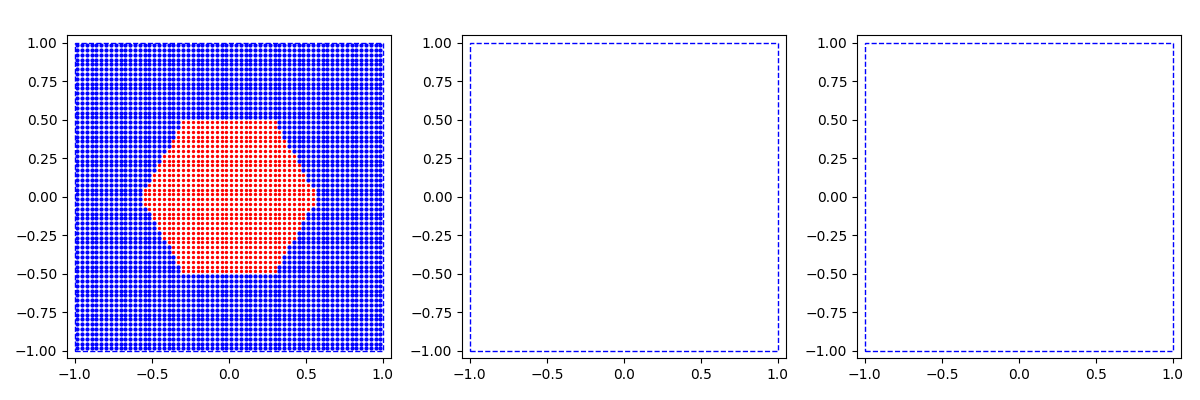

In [50]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

for ax in axis.flatten():    
    domainMin = config['domain']['minExtent']
    domainMax = config['domain']['maxExtent']
    square = patches.Rectangle((domainMin[0].detach().cpu().numpy(), domainMin[1].detach().cpu().numpy()), domainMax[0].detach().cpu().numpy() - domainMin[0].detach().cpu().numpy(), domainMax[1].detach().cpu().numpy() - domainMin[1].detach().cpu().numpy(), linewidth=1, edgecolor='b', facecolor='none',ls='--')
    ax.add_patch(square)
    ax.set_aspect('equal')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)

axis[0,0].scatter(boundaryParticles[:,0].detach().cpu().numpy(), boundaryParticles[:,1].detach().cpu().numpy(), c = 'red', s = 2)
axis[0,0].scatter(fluidState['fluidPositions'][fluidMask][:,0].detach().cpu().numpy(), fluidState['fluidPositions'][fluidMask][:,1].detach().cpu().numpy(), c = 'blue', s = 4)

# scatterPlotSymmetric(fig, axis[0,0], boundaryParticles, boundaryParticles.new_ones(boundaryParticles.shape[0]), config['domain']['minExtent'], config['domain']['maxExtent'], '$f(x)$', cmap = 'twilight_r', s = 8)
# scatterPlotSymmetric(fig, axis[0,1], boundaryParticles, boundaryNormals[:,0], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial x} f(x)$', cmap = 'Spectral', s = 8)
# scatterPlotSymmetric(fig, axis[0,2], boundaryParticles, boundaryNormals[:,1], config['domain']['minExtent'], config['domain']['maxExtent'], '$\\frac{\\partial}{\\partial y} f(x)$', cmap = 'Spectral', s = 8, cbar = False)

fig.tight_layout()